In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

In [4]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240224-103820_task_0/model_10000000.pt"
model = QNetwork(frame_stacks=1, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240224-103820_task_0/model_10000000.pt


In [5]:
concept = concept_instances['visible bullet']
hyperparameters = {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 512}
TCAVs = []

In [6]:
for _ in range(20):
    concept.prepare_data(env_steps, max_size=10000)
    probe, info = train_probes(model, concept, hyperparameters, [layer])
    #print(info[layer])
    score = info[layer]['test_score'][-1]
    probe = probe[layer]
    #probe, score = concept.load_torch_probe()
    print(f'{concept.name}: {score}')
    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)

    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]

    # Additional forward pass to get gradients (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Flatten the activations
    acts_flat = acts.reshape(acts.shape[0], -1)

    # Initialize tensor to store results
    directional_derivatives = torch.zeros_like(q_values)

    # Compute directional derivatives
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        # Calculate directional derivative
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        directional_derivatives[:, j] = torch.mv(grads_flat, CAV)

        acts.grad.zero_()

    TCAV = sum(directional_derivatives > 0) / directional_derivatives.shape[0]
    #print(f'TCAV: {TCAV}')
    TCAVs.append(TCAV.cpu().numpy().mean())

visible bullet: 0.8975282907485962
visible bullet: 0.8794450461864471
visible bullet: 0.8896147608757019
visible bullet: 0.8861799538135529
visible bullet: 0.8997844755649567
visible bullet: 0.8580953776836395
visible bullet: 0.9017039239406586
visible bullet: 0.8909617364406586
visible bullet: 0.8935883641242981
visible bullet: 0.8936893939971924
visible bullet: 0.9155778586864471
visible bullet: 0.8928475081920624
visible bullet: 0.8817349076271057
visible bullet: 0.8899178206920624
visible bullet: 0.8753367364406586
visible bullet: 0.8912648260593414
visible bullet: 0.8892106711864471
visible bullet: 0.9041621685028076
visible bullet: 0.8707906901836395
visible bullet: 0.9000202119350433


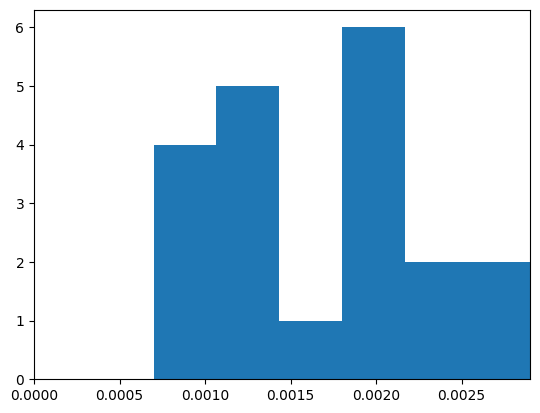

In [7]:
plt.hist(TCAVs, bins='auto')
plt.xlim(0, max(TCAVs))
plt.show()